In [1]:
from __future__ import print_function
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import balanced_accuracy_score
from matplotlib import pyplot as plt
import re
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
import numpy
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD
from keras.constraints import maxnorm
import pickle 
#pd.set_option('display.max_colwidth', 2000) # To visualize full output
pd.set_option("display.max_rows", None, "display.max_columns", None)

Using TensorFlow backend.


In [3]:
data_whole = pd.read_csv('../data/OE_labeled.csv')
data_extra = pd.read_csv('../data/OE_labeled_extra.csv')
data_whole = pd.concat([data_whole, data_extra])
data_whole = data_whole[~data_whole['Label'].isna()].reset_index(drop=True)
data_whole['Label'] = data_whole['Label'].astype(int)
df_main=data_whole
len(df_main)

1098

In [4]:
def preprocess(tweet):
  tweet = tweet.replace('@ ','@').replace('# ','#')
  tweet = re.sub('pic.twitter.com.*','',tweet)
  tweet = re.sub('https*://[^\s]+','',tweet)
  tweet = re.sub('https*://.*','',tweet)
  #tweet = ' '.join(word for word in tweet.split() if anyalnum(word))
  return tweet

In [5]:
df = df_main
df['Tweet text processed'] = df['tweet'].apply(preprocess)

In [6]:
print('before',len(df))
df = df.drop_duplicates(subset='Tweet text processed')
print('after',len(df))

before 1098
after 1093


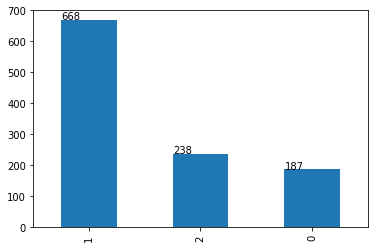

In [7]:
ax = df['Label'].value_counts().plot(kind='bar')
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

In [8]:
df = df.reset_index(drop = True)
df.head(1)

,tweet,Label,cashtags,conversation_id,created_at,date,day,favorites,geo,has_media,hashtags,hour,id,img_urls,is_replied,is_reply_to,likes,link,links,mentions,name,near,nlikes,nreplies,nretweets,parent_tweet_id,place,quote_url,replies,reply_to,reply_to_users,retweet,retweet_date,retweet_id,retweets,screen_name,search,source,text_html,timestamp_epochs,timezone,trans_dest,trans_src,translate,tweet_id,user_id,user_id_str,user_rt,user_rt_id,username,video_url,lang,Unnamed: 0,Unnamed: 0.1,corrected_id,pred_new,pred_old,Tweet text processed
0,"Everyone : auto, cabs, women, car with a child...",0,NaN,NaN,NaN,2019-11-04 13:41,NaN,5.0,NaN,NaN,# # #,NaN,1.190000e+18,NaN,NaN,NaN,NaN,https://twitter.com/Anurag90420472/status/1191...,NaN,@,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Anurag90420472,NaN,en,NaN,NaN,NaN,NaN,NaN,"Everyone : auto, cabs, women, car with a child..."


In [9]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU 
from tensorflow.keras.layers import Dense, Embedding, LSTM, GRU, Bidirectional
from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

toc = Tokenizer()
toc.fit_on_texts(df['Tweet text processed'])

max_len = max(len(s.split()) for s in df['Tweet text processed'])

vocab_size = len(toc.word_index) + 1

In [10]:
from itertools import product
from sklearn.metrics import balanced_accuracy_score

def create_model(embedding_dim, neurons):
	# create model
  model = Sequential()
  model.add(Embedding(vocab_size, embedding_dim, input_length=max_len))
  model.add(Bidirectional(LSTM(32, return_sequences=True)))
  model.add((Bidirectional(LSTM(neurons))))
  #model.add(Dense(64, activation='relu'))
  #model.add(Dense(3, activation='relu'))
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model
def GridSearchCV(X, y, train_val_index, y_train_val, param_grid):
  hyperpara_dict = {}
  # kfInner = StratifiedKFold(5, shuffle=True, random_state=0) # latest working
  # train_ind, val_ind = next(kfInner.split(train_val_index, y_train_val.idxmax(axis=1).values)) # latest working
  # train_df_ind = train_val_index[train_ind] # latest working
  # val_df_ind = train_val_index[val_ind] # latest working
  train_df_ind, val_df_ind = train_test_split(train_val_index, random_state=0, test_size=0.2)
    
  X_train, y_train = X.iloc[train_df_ind], y.iloc[train_df_ind]
  X_val, y_val = X.iloc[val_df_ind], y.iloc[val_df_ind]

  train_tocs = toc.texts_to_sequences(X_train)
  val_tocs = toc.texts_to_sequences(X_val)
  X_train_pad = pad_sequences(train_tocs, maxlen=max_len, padding='post')
  X_val_pad = pad_sequences(val_tocs, maxlen=max_len, padding='post')
  
  for embedding_dim, neurons, batch_size, epochs in product(*param_grid.values()):
    print('searching', (embedding_dim, neurons, batch_size, epochs))
    model = create_model(embedding_dim, neurons)
    model.fit(X_train_pad, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    res = model.predict(X_val_pad)
    score = pd.DataFrame(res).max(axis =1)
    y_pred = pd.DataFrame(res, columns=[-1,0,1]).idxmax(axis=1)
    accuracy = f1_score(y_val.idxmax(axis=1), y_pred,average='macro')
    hyperpara_dict.update({(embedding_dim, neurons, batch_size, epochs) : accuracy})
  return max(hyperpara_dict, key=lambda x: hyperpara_dict[x]) # will return set of hyp having max accuracy


In [11]:
# Main code
from sklearn.model_selection import train_test_split
X = df['Tweet text processed']
y = pd.get_dummies(df['Label'])
param_grid = {'embedding_dim':[32,64,128], 
               'neurons':[8,16,32,64], 
               'batch_size':[8,16,32], 
               'epochs' : [20, 30,50, 100]}
from sklearn.model_selection import StratifiedKFold, KFold
# kf = StratifiedKFold() # latest working
kf = KFold(5, shuffle=True, random_state=0)
test_inds = []
test_preds = []
test_score = []
test = []
for train_val_index, test_index in kf.split(X, y.idxmax(axis=1)):
  X_train_val, X_test = X.iloc[train_val_index], X.iloc[test_index]
  y_train_val, y_test = y.iloc[train_val_index], y.iloc[test_index]
  train_val_tocs = toc.texts_to_sequences(X_train_val)
  test_tocs = toc.texts_to_sequences(X_test)
  X_train_val_pad = pad_sequences(train_val_tocs, maxlen=max_len, padding='post')
  X_test_pad = pad_sequences(test_tocs, maxlen=max_len, padding='post')

  # Start Hyperpara tuning
  embedding_dim, neurons, batch_size, epochs = GridSearchCV(X, y, train_val_index, y_train_val, param_grid)
  print('best hyper', embedding_dim, neurons, batch_size, epochs)
  model = create_model(embedding_dim, neurons)
  model.fit(X_train_val_pad, y_train_val, batch_size=batch_size, epochs=epochs, verbose=0)
  res = model.predict(X_test_pad)
  score = pd.DataFrame(res).max(axis =1)
  y_pred = pd.DataFrame(res, columns=[-1,0,1]).idxmax(axis=1)
  accuracy = f1_score(y_test.idxmax(axis=1), y_pred,average='macro')
  print(accuracy)
  test_inds.extend(test_index)
  test_preds.extend(y_pred)
  test_score.extend(score)
  test.extend(y_test.idxmax(axis=1))

searching (32, 8, 8, 20)
searching (32, 8, 8, 30)
searching (32, 8, 8, 50)
searching (32, 8, 8, 100)
searching (32, 8, 16, 20)
searching (32, 8, 16, 30)
searching (32, 8, 16, 50)
searching (32, 8, 16, 100)
searching (32, 8, 32, 20)
searching (32, 8, 32, 30)
searching (32, 8, 32, 50)
searching (32, 8, 32, 100)
searching (32, 16, 8, 20)
searching (32, 16, 8, 30)
searching (32, 16, 8, 50)
searching (32, 16, 8, 100)
searching (32, 16, 16, 20)
searching (32, 16, 16, 30)
searching (32, 16, 16, 50)
searching (32, 16, 16, 100)
searching (32, 16, 32, 20)
searching (32, 16, 32, 30)
searching (32, 16, 32, 50)
searching (32, 16, 32, 100)
searching (32, 32, 8, 20)
searching (32, 32, 8, 30)
searching (32, 32, 8, 50)
searching (32, 32, 8, 100)
searching (32, 32, 16, 20)
searching (32, 32, 16, 30)
searching (32, 32, 16, 50)
searching (32, 32, 16, 100)
searching (32, 32, 32, 20)
searching (32, 32, 32, 30)
searching (32, 32, 32, 50)
searching (32, 32, 32, 100)
searching (32, 64, 8, 20)
searching (32, 64

searching (32, 16, 8, 50)
searching (32, 16, 8, 100)
searching (32, 16, 16, 20)
searching (32, 16, 16, 30)
searching (32, 16, 16, 50)
searching (32, 16, 16, 100)
searching (32, 16, 32, 20)
searching (32, 16, 32, 30)
searching (32, 16, 32, 50)
searching (32, 16, 32, 100)
searching (32, 32, 8, 20)
searching (32, 32, 8, 30)
searching (32, 32, 8, 50)
searching (32, 32, 8, 100)
searching (32, 32, 16, 20)
searching (32, 32, 16, 30)
searching (32, 32, 16, 50)
searching (32, 32, 16, 100)
searching (32, 32, 32, 20)
searching (32, 32, 32, 30)
searching (32, 32, 32, 50)
searching (32, 32, 32, 100)
searching (32, 64, 8, 20)
searching (32, 64, 8, 30)
searching (32, 64, 8, 50)
searching (32, 64, 8, 100)
searching (32, 64, 16, 20)
searching (32, 64, 16, 30)
searching (32, 64, 16, 50)
searching (32, 64, 16, 100)
searching (32, 64, 32, 20)
searching (32, 64, 32, 30)
searching (32, 64, 32, 50)
searching (32, 64, 32, 100)
searching (64, 8, 8, 20)
searching (64, 8, 8, 30)
searching (64, 8, 8, 50)
searchin

searching (32, 32, 8, 100)
searching (32, 32, 16, 20)
searching (32, 32, 16, 30)
searching (32, 32, 16, 50)
searching (32, 32, 16, 100)
searching (32, 32, 32, 20)
searching (32, 32, 32, 30)
searching (32, 32, 32, 50)
searching (32, 32, 32, 100)
searching (32, 64, 8, 20)
searching (32, 64, 8, 30)
searching (32, 64, 8, 50)
searching (32, 64, 8, 100)
searching (32, 64, 16, 20)
searching (32, 64, 16, 30)
searching (32, 64, 16, 50)
searching (32, 64, 16, 100)
searching (32, 64, 32, 20)
searching (32, 64, 32, 30)
searching (32, 64, 32, 50)
searching (32, 64, 32, 100)
searching (64, 8, 8, 20)
searching (64, 8, 8, 30)
searching (64, 8, 8, 50)
searching (64, 8, 8, 100)
searching (64, 8, 16, 20)
searching (64, 8, 16, 30)
searching (64, 8, 16, 50)
searching (64, 8, 16, 100)
searching (64, 8, 32, 20)
searching (64, 8, 32, 30)
searching (64, 8, 32, 50)
searching (64, 8, 32, 100)
searching (64, 16, 8, 20)
searching (64, 16, 8, 30)
searching (64, 16, 8, 50)
searching (64, 16, 8, 100)
searching (64, 1

In [12]:
pd.to_pickle(test, 'test_OE_extra')
pd.to_pickle(test_preds, 'test_preds_OE_extra')

In [13]:
print(classification_report(test, np.array(test_preds)+1))
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import classification_report, balanced_accuracy_score, confusion_matrix
# from sklearn.model_selection import train_test_split
# print(test_preds)
# sns.heatmap((confusion_matrix(test,test_preds)),annot=True,annot_kws={"size": 40},cbar=False,fmt='g',
#             xticklabels=[-1,0,1], yticklabels=[-1,0,1])

# plt.xlabel('predicted')
# plt.ylabel('ground truth')
# plt.show()

              precision    recall  f1-score   support

           0       0.37      0.31      0.34       187
           1       0.72      0.69      0.70       668
           2       0.38      0.48      0.42       238

    accuracy                           0.58      1093
   macro avg       0.49      0.49      0.49      1093
weighted avg       0.59      0.58      0.58      1093

